## Calc the predicted azimuth offset from TEC gradient and compare with SAR

In [1]:
%matplotlib inline
import os
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt, ticker
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from tools.simulation import iono
from tools import iono_tec
from ipynb.fs.full import utils
plt.rcParams.update({'font.size': 12})

# constatns
K = 40.31
SPEED_OF_LIGHT = 299792458.

proj_dir = os.path.expanduser('~/data/geolocation/KyushuAlos2DT23')

work_dir = os.path.join(proj_dir, 'offset_comp')
os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/data/geolocation/KyushuAlos2DT23/offset_comp


In [2]:
# utils functions
def read_tec_grad_file(tec_grad_file, date_list, fill_value=np.nan):
    num_date = len(date_list)
    tec_grad_lat     = np.zeros(num_date, dtype=np.float32) * fill_value
    tec_grad_lat_rms = np.zeros(num_date, dtype=np.float32) * fill_value
    tec_grad_lat_std = np.zeros(num_date, dtype=np.float32) * fill_value
    tec_grad_lon     = np.zeros(num_date, dtype=np.float32) * fill_value
    tec_grad_lon_rms = np.zeros(num_date, dtype=np.float32) * fill_value
    tec_grad_lon_std = np.zeros(num_date, dtype=np.float32) * fill_value

    fc = np.loadtxt(tec_grad_file, dtype=bytes).astype(str)

    # mask out data without obs
    flag = fc[:, -1].astype(np.int16) > 0

    # read date
    tec_date_list = fc[:, 0][flag].tolist()
    flagD = np.array([i in tec_date_list for i in date_list], dtype=np.bool_)

    # read data
    tec_grad_lat[flagD], tec_grad_lat_rms[flagD], tec_grad_lat_std[flagD] = fc[:, (1,2,3)].astype(np.float32)[flag, :].T
    tec_grad_lon[flagD], tec_grad_lon_rms[flagD], tec_grad_lon_std[flagD] = fc[:, (4,5,6)].astype(np.float32)[flag, :].T

    return date_list, tec_grad_lat, tec_grad_lon, tec_grad_lat_rms, tec_grad_lon_rms, tec_grad_lat_std, tec_grad_lon_std


def east_north2azimuth(v_e, v_n, head_angle=-168.):
    """Convert 2D value in East, North direction into SAR azimuth (along-track) direction."""
    head_angle = float(head_angle) * np.pi / 180.
    v_az = (  v_e * np.sin(head_angle) * -1 
            + v_n * np.cos(head_angle) * -1)
    return v_az

def azimuth_tec_grad2shift(tec_grad_az, atr):
    """Convert the TEC gradient in azimuth direction into SAR pixel shift in azimuth direction."""
    Vsat = float(atr['satelliteSpeed'])
    Hsat = float(atr['altitude'])
    wvl = float(atr['radarWavelength'])
    Re = float(atr['earthRadius'])
    rng0 = float(atr['startingRange'])
    Vground = Vsat * Re / (Re + Hsat)
    freq = SPEED_OF_LIGHT / wvl

    doppler_shift = 2. * K * iono_height * Vsat * (tec_grad_az * 1e16 / 1e3) / Hsat / wvl
    time_shift    = 1. * K * iono_height * rng0 * (tec_grad_az * 1e16 / 1e3) / Hsat / (freq**2 * Vsat)
    az_shift = time_shift * Vground
    return az_shift, doppler_shift

In [3]:
# read geometry
ts_file   = os.path.join(proj_dir, 'mintpy_offset/timeseriesAz.h5')
mask_file = os.path.join(proj_dir, 'mintpy_offset/maskResInv.h5')
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
atr = readfile.read_attribute(ts_file)
date_list = timeseries(ts_file).get_date_list()
num_date = len(date_list)

# read SAR offset
mask = readfile.read(mask_file)[0].flatten()
ts_data = readfile.read(ts_file, )[0].reshape(num_date, -1)
ts_data[:, mask==0] = np.nan
az_shift_sar = np.nanmedian(ts_data, axis=-1)

# read text file from Xiaoqing
tec_grad_file = os.path.join(proj_dir, 'GIM_TEC/ssTECgrad.txt')
(tec_grad_lat,
 tec_grad_lon,
 tec_grad_lat_rms,
 tec_grad_lon_rms,
 tec_grad_lat_std,
 tec_grad_lon_std) = read_tec_grad_file(tec_grad_file, date_list)[1:]

(iono_inc_angle,
 iono_lat,
 iono_lon,
 iono_height) = iono.prep_geometry_iono_shell_along_los(geom_file, box=None, iono_height=450e3, print_msg=True)
iono_inc_angle = np.mean(iono_inc_angle)
head_angle = float(atr['HEADING'])
print('heading angle: {:.1f} deg'.format(head_angle))

# calc TEC gradient in azimuth direction
tec_grad_az     = east_north2azimuth(tec_grad_lon,     tec_grad_lat,     head_angle=head_angle)
tec_grad_az_rms = east_north2azimuth(tec_grad_lon_rms, tec_grad_lat_rms, head_angle=head_angle)
tec_grad_az_std = east_north2azimuth(tec_grad_lon_std, tec_grad_lat_std, head_angle=head_angle)

# convert TEC grad into azimuth shift in meter
az_shift_tec     = azimuth_tec_grad2shift(tec_grad_az, atr)[0]
az_shift_tec_rms = azimuth_tec_grad2shift(tec_grad_az_rms, atr)[0]
az_shift_tec_std = azimuth_tec_grad2shift(tec_grad_az_std, atr)[0]

incidence angle on the ground     min/max: 34.2/38.1 deg
incidence angle on the ionosphere min/max: 31.6/35.2 deg
center lat/lon  on the ground    : 32.0677/130.7736 deg
center lat/lon  on the ionosphere: 29.3923/130.2832 deg
heading angle: -169.6 deg


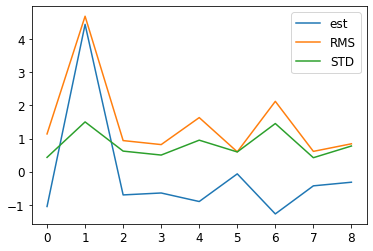

In [20]:
flag = ~np.isnan(az_shift_tec)
plt.plot(az_shift_tec[flag],     label='est')
plt.plot(az_shift_tec_rms[flag], label='RMS')
plt.plot(az_shift_tec_std[flag], label='STD')
plt.legend()
plt.show()

## Plot TS

RMSE:
  SAR          : 88.9 cm
  SAR - TECgrad: 179.9 cm
save figure to file /Users/yunjunz/data/geolocation/KyushuAlos2DT23/offset_comp/TS_AZ_SAR_vs_TECgrad.png


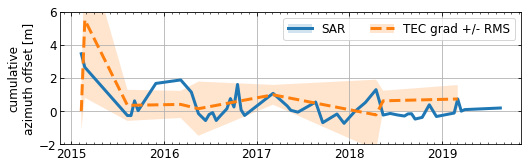

In [7]:
x1 = ptime.date_list2vector(date_list)[0]
y1 = az_shift_sar - np.nanmedian(az_shift_sar)
y2 = az_shift_tec - np.nanmedian(az_shift_tec - y1)
y1e = np.zeros(y1.shape, dtype=np.float32)
#y2e = az_shift_tec_std;
y2e = az_shift_tec_rms;

# RMSE
print('RMSE:')
rmse = ut.root_mean_sq_error(y1);     print('  SAR          : {:.1f} cm'.format(rmse*100))
rmse = ut.root_mean_sq_error(y1, y2); print('  SAR - TECgrad: {:.1f} cm'.format(rmse*100))

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7.5, 2.5])
ps = []
for i, (y, ye, c, mk) in enumerate(zip([y1, y2], [y1e, y2e], ['C0', 'C1'], ['-', '--'])):
    flag = ~np.isnan(y)
    y  = np.array(y)[flag]
    ye = np.array(ye)[flag]
    x  = np.array(x1)[flag]
    p0  = ax.fill_between(x, y-ye, y+ye, fc=c, ec='none', alpha=0.2)
    p1, = ax.plot(x, y, mk, color=c, ms=4, lw=3)
    ps.append((p0, p1))
# axis format
ylim = [-2, 6]; vstep = 2;
utils.adjust_ts_axis_format(ax, x=x1, vstep=vstep, ylim=ylim, ylabel='cumulative\nazimuth offset [m]')
ax.legend(handles=ps, labels=['SAR', 'TEC grad +/- RMS'], loc='best', ncol=len(ps))
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_AZ_SAR_vs_TECgrad.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Plot DOT

$RMSE$ = 179.9 cm
$R^2$ = 0.35

save figure to file /Users/yunjunz/data/geolocation/KyushuAlos2DT23/offset_comp/DOT_AZ_SAR_vs_TECgrad.pdf


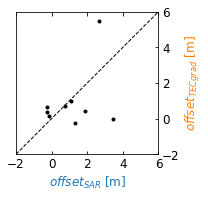

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[2.7, 2.7])
utils.plot_dot_figure(ax, x=y1[flag], y=y2, vlim=ylim, vstep=vstep)
fig.tight_layout()
ax.set_xlabel('$offset_{{{}}}$ [m]'.format('SAR'),     color='C0')
ax.set_ylabel('$offset_{{{}}}$ [m]'.format('TECgrad'), color='C1', labelpad=None)
# output
out_fig = os.path.join(work_dir, 'DOT_AZ_SAR_vs_TECgrad.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)